<a href="https://colab.research.google.com/github/Mohanvarmad/Machine-Learning/blob/master/optimization/Eric's_Objective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyomo
!apt-get install -y -qq coinor-cbc

     |████████████████████████████████| 9.5MB 3.9MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 256kB 40.6MB/s 
     |████████████████████████████████| 163kB 53.1MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 146364 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coi

### Importing packages

In [6]:
import pandas as pd
import numpy as np
import pyomo as pyo
from pyomo.environ import ConcreteModel, Var, PositiveReals, Objective, Constraint, maximize, SolverFactory, ConstraintList
from pyomo.environ import *
from pyomo.opt import SolverFactory


### Eric's scenario

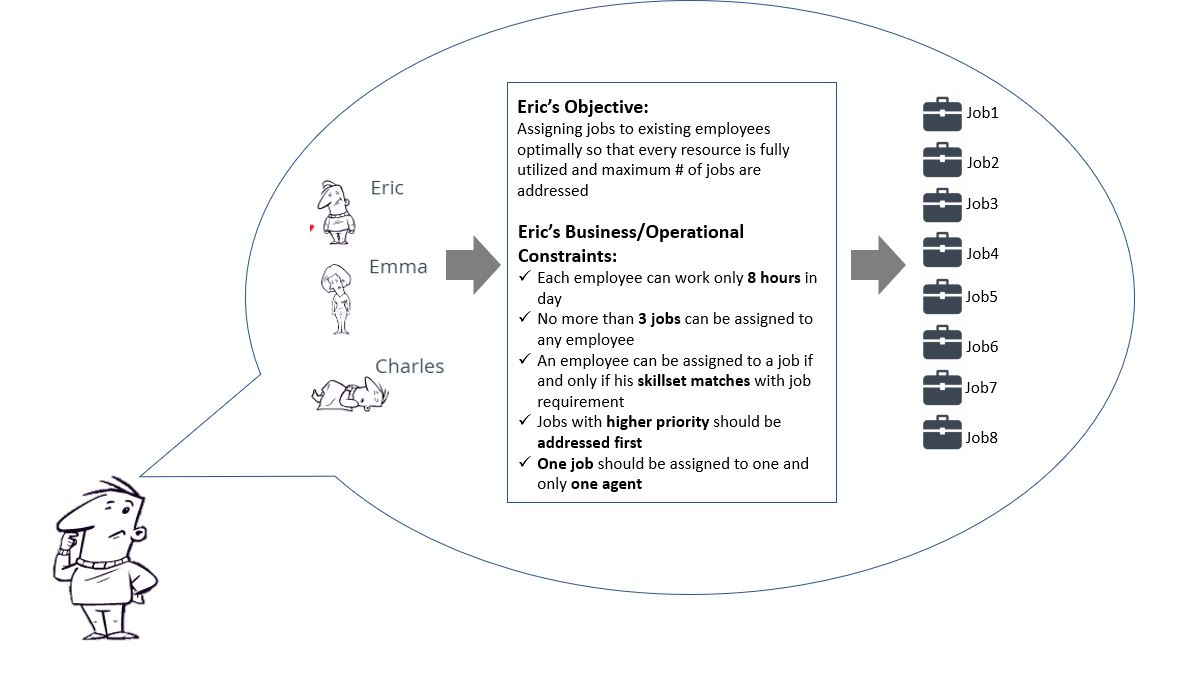

### Data preparation

In [85]:
employees = ['Eric', 'Emma', 'Charles']
employeeSkillset= {'Eric': ['Skill1'], 'Emma': ['Skill1', 'Skill2'], 'Charles': ['Skill2']}

jobs = ["Job" + str(i) for i in range(1, 9)]
jobSkillDemand = {'Job1': 'Skill1', 'Job2': 'Skill1', 'Job3': 'Skill1', 'Job4': 'Skill1', 'Job5': 'Skill2', 'Job6': 'Skill2', 'Job7': 'Skill2', 'Job8': 'Skill2' }

timeNeeded = [np.random.randint(1, 6) for i in range(1, 9)]
priority = [np.random.randint(1,4) for i in range(1,9)]  ## Lower the priority number higher is the priority

jobTime = {job:time for job, time in zip(jobs, timeNeeded)}
jobPrio = {job:pri for job, pri in zip(jobs, priority)} 
empCapacity = {'Eric': 8, 'Emma': 8, 'Charles': 8}


In [86]:
print('List of employees:', employees)
print('Employee Capacity (in hrs per day):', empCapacity)
print('Job List:', jobs)
print('Time needed to work on jon:', timeNeeded)
print('Priority of job:', priority)
print('Dict of job and time needed (in hrs):', jobTime)
print('Dict of jon and its priority:', jobPrio)


List of employees: ['Eric', 'Emma', 'Charles']
Employee Capacity (in hrs per day): {'Eric': 8, 'Emma': 8, 'Charles': 8}
Job List: ['Job1', 'Job2', 'Job3', 'Job4', 'Job5', 'Job6', 'Job7', 'Job8']
Time needed to work on jon: [4, 5, 1, 4, 1, 4, 1, 4]
Priority of job: [2, 1, 2, 2, 1, 2, 2, 1]
Dict of job and time needed (in hrs): {'Job1': 4, 'Job2': 5, 'Job3': 1, 'Job4': 4, 'Job5': 1, 'Job6': 4, 'Job7': 1, 'Job8': 4}
Dict of jon and its priority: {'Job1': 2, 'Job2': 1, 'Job3': 2, 'Job4': 2, 'Job5': 1, 'Job6': 2, 'Job7': 2, 'Job8': 1}


### Modeling building

In [98]:
# Create the concrete model
model = ConcreteModel()

In [99]:
model.employeeJobAssigment = Var(((emp, job) for emp in employees for job in jobs), within = Binary, initialize=0)

In [100]:
# Defining constraints
model.constraints = ConstraintList()

In [101]:
## Capacity Constraint: Employee cannot work more than 8 hours in a day
for emp in employees:
    model.constraints.add(empCapacity[emp] >= sum(model.employeeJobAssigment[emp, job]*jobTime[job] for job in jobs))
    
## Job Count Constraint: No more than 3 jobs per employee
for emp in employees:
    model.constraints.add(3 >= sum(model.employeeJobAssigment[emp, job] for job in jobs))

## Job to agent mappping: One job should be assigned to one and only one agent
for job in jobs:
  model.constraints.add(1 >= sum(model.employeeJobAssigment[emp, job] for emp in employees))

## Skill match: An employee can be assigned to a job if and only if his skillset matches with job demand
for emp in employees:
  for job in jobs:
    if jobSkillDemand[job] not in employeeSkillset[emp]:
      model.constraints.add(0 == model.employeeJobAssigment[emp, job])

In [102]:
# Objective: Minimizing total assignment time

def assignmentObjective(m):
    
    return -sum(m.employeeJobAssigment[emp, job]/jobPrio[job] for emp in employees for job in jobs) ## with penalization for job priority

model.obj = Objective(rule=assignmentObjective, sense=minimize)

### Solving model

In [103]:
opt = SolverFactory('cbc')  # choose a solver
results = opt.solve(model) 

In [104]:
solutionDf = pd.DataFrame({'employee': [i[0] for i in model.employeeJobAssigment.iterkeys()], 'Job': [i[1] for i in model.employeeJobAssigment.iterkeys()], 'assignment': [i.value for i in model.employeeJobAssigment.itervalues()]})
solutionDf = solutionDf[solutionDf['assignment'] == 1]

In [105]:
solutionDf['job time'] = [jobTime[job] for job in solutionDf['Job']]
solutionDf['priority'] = [jobPrio[job] for job in solutionDf['Job']]
solutionDf['job skill demand'] = [jonSkillDemand[job] for job in solutionDf['Job']]

In [106]:
solutionDf

,employee,Job,assignment,job time,priority,job skill demand
0,Eric,Job1,1.0,4,2,Skill1
3,Eric,Job4,1.0,4,2,Skill1
9,Emma,Job2,1.0,5,1,Skill1
10,Emma,Job3,1.0,1,2,Skill1
12,Emma,Job5,1.0,1,1,Skill2
22,Charles,Job7,1.0,1,2,Skill2
23,Charles,Job8,1.0,4,1,Skill2
